# 2. Ley de gravitación universal con más entradas

En este cuadernillo repetiremos el experimento de **00_grav_law**, pero añadiendo más entradas a la red neuronal. Las entradas que añadimos no están relacionadas con la función que queremos predecir y el objetivo es ver cómo se comporta el modelo.

Repetimos los mismo pasos que en el cuadernillo anterior. Solo se destacan los cambios más relevantes.

A continuación, definimos las funciones para crear los conjuntos de datos.

In [1]:
from kan import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Genera una muestra de n observaciones de la variable aleatoria X
def dataset_point(n, r_min=1.295, r_max=5.0):
    u = torch.rand(n)
    r_cubed = u * (r_max**3 - r_min**3) + r_min**3
    r = r_cubed**(1/3)

    u_theta = torch.rand(n)
    u_phi = torch.rand(n)
    theta = torch.acos(1 - 2 * u_theta)
    phi = 2 * torch.pi * u_phi

    x = r * torch.sin(theta) * torch.cos(phi)
    y = r * torch.sin(theta) * torch.sin(phi)
    z = r * torch.cos(theta)

    return torch.stack((x, y, z), dim=1)

# Genera una muestra de n observaciones de la variable aleatoria D
def dataset_distance(n, r_min=1.3, r_max=5.0):
    points = dataset_point(2*n, r_min, r_max)
    p1 = points[:n]
    p2 = points[n:]
    return torch.norm(p1 - p2, dim=1)

# Genera una muestra de n observaciones de la variable aleatoria M
def dataset_mass(n, m_min=0.5, m_max=5.0, alpha=2.3):
    inv = 1.0 - alpha
    lower = m_min**inv
    upper = m_max**inv

    u = torch.rand(n)
    m = (lower + u*(upper - lower))**(1.0/inv)
    return m

La siguiente función genera el conjunto de datos con dos variables $x_1$ y $x_2$ que no están relacionadas con la función $F$.

In [16]:
def create_dataset_extra_input(train_num=20000, test_num=10000):

    # Esta función genera un conjunto de datos (x,y) con una cantidad de datos menor a num (porque algunos se filtran)
    def generate_grav(num):
        # Generamos las distancias y filtramos
        d = dataset_distance(num, 1.295, 5)
        d = d[d > 1]

        # Generamos las masas una vez hemos filtrado
        new_num = len(d)
        m1 = dataset_mass(new_num)
        m2 = dataset_mass(new_num)

        # Calculamos el valor de F
        G = 2.773
        F = G*(m1*m2)/(d**2)

        # Añadimos variables irrelaventes
        x1 = 1 + 4*torch.distributions.Beta(2.0, 5.0).sample((new_num, )) # Toma valores entre [1,4]
        x2 = 1 + 4*torch.distributions.Beta(5.0, 2.0).sample((new_num, )) # Toma valores entre [1,4]

        x = torch.stack([m1, m2, d, x1, x2], dim=1)
        y = F.unsqueeze(dim=1)

        # Filtramos las valores de F muy pequeños
        mask = (y.squeeze() > 0.1)
        x = x[mask]
        y = y[mask]

        return x,y

    x_train, y_train = generate_grav(train_num)
    x_test, y_test = generate_grav(test_num)

    dataset = {}
    dataset['train_input'] = x_train.to(device)
    dataset['test_input'] = x_test.to(device)
    dataset['train_label'] = y_train.to(device)
    dataset['test_label'] = y_test.to(device)
    return dataset

In [23]:
# Iniciamos la KAN
model = KAN(width=[5,5,1], grid=3, k=3, seed=2020, device=device);

dataset = create_dataset_extra_input()

checkpoint directory created: ./model
saving model version 0.0


In [24]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.03);

| train_loss: 1.80e-01 | test_loss: 3.28e-01 | reg: 5.20e+00 | : 100%|█| 50/50 [00:13<00:00,  3.75it

saving model version 0.1


Esta gráfica muestra como el modelo ha sido capaz de darse cuenta que las dos últimas entradas no están relacionadas con la función que tratamos de aprender.

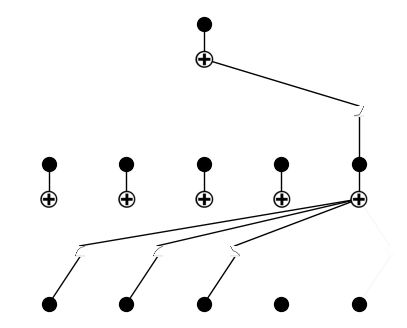

In [25]:
# Visualizamos la red
model.plot()

In [26]:
# Podamos la red
pruned_model = model.prune(node_th=1e-1, edge_th=1e-1)

saving model version 0.2


Una vez hemos realizado la poda, esas entradas ya no se muestran.

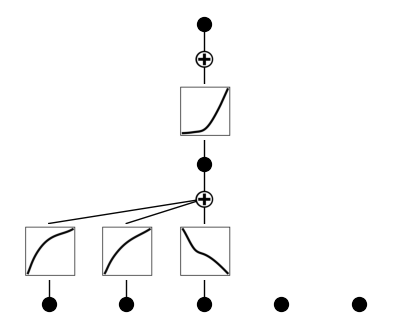

In [27]:
# Mostramos el modelo podado
pruned_model.plot()

In [28]:
# Volvemos a entrenar el modelo tras la poda
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 1.65e-02 | test_loss: 3.23e-02 | reg: 8.47e+00 | : 100%|█| 100/100 [00:20<00:00,  4.94

saving model version 0.3


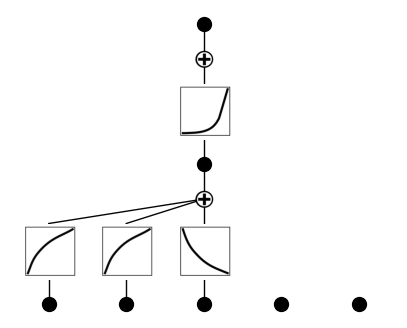

In [29]:
pruned_model.plot()

In [30]:
# Vamos a ver si podemos ajustar funciones simbólicas
pruned_model.suggest_symbolic(0,0,0);
pruned_model.suggest_symbolic(0,1,0);
pruned_model.suggest_symbolic(0,2,0);
pruned_model.suggest_symbolic(1,0,0);

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        log    0.999687 -11.597049           2                2   -0.719410
1    1/x^0.5    0.999627 -11.351694           2                2   -0.670339
2  1/sqrt(x)    0.999627 -11.351694           2                2   -0.670339
3        1/x    0.999347 -10.558901           2                2   -0.511780
4      1/x^2    0.998908  -9.825404           2                2   -0.365081
    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^0.5    0.999625 -11.341839           2                2   -0.668368
1  1/sqrt(x)    0.999625 -11.341839           2                2   -0.668368
2        log    0.999577 -11.172901           2                2   -0.634580
3        1/x    0.999387 -10.647436           2                2   -0.529487
4      1/x^2    0.998978  -9.920534           2                2   -0.384107
    function  fitting r2    r2 loss  complexity  complexity loss  total loss

Podemos utilizar un razonamiento similar al del otro cuardernillo para elegir $\log$ en la primera capa y $\exp$ en la segunda.

In [31]:
# Fijamos las funciones de activación a las funciones simbólicas siguientes
pruned_model.fix_symbolic(0,0,0, 'log');
pruned_model.fix_symbolic(0,1,0, 'log');
pruned_model.fix_symbolic(0,2,0, 'log');
pruned_model.fix_symbolic(1,0,0, 'exp');

r2 is 0.9996871948242188
saving model version 0.4
r2 is 0.9995768666267395
saving model version 0.5
r2 is 0.9996771812438965
saving model version 0.6
r2 is 0.9997775554656982
saving model version 0.7


Volvemso a entrenar el modelo y vemos el resultado.

In [32]:
# Volvemos a entrenar el modelo
pruned_model.fit(dataset, opt="LBFGS", steps=100);

| train_loss: 2.83e-07 | test_loss: 2.83e-07 | reg: 0.00e+00 | : 100%|█| 100/100 [00:09<00:00, 10.75

saving model version 0.8


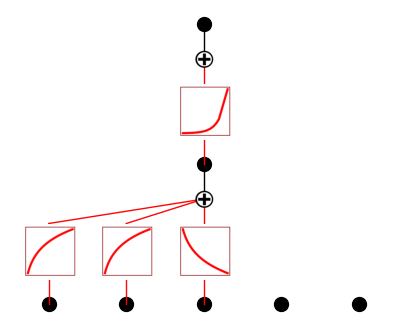

In [33]:
pruned_model.plot()

Como podemos ver, obtenemos una aproximación muy buena donde las dos variables que hemos introducido de forma artificial no aparecen.

In [34]:
formula = pruned_model.symbolic_formula()[0][0]
ex_round(formula, 4)

2.773*x_1**1.0*x_2**1.0/x_3**2.0

In [138]:
# Entrenamos la red con regularización
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.02);

| train_loss: 2.56e-01 | test_loss: 2.24e-01 | reg: 5.66e+00 | : 100%|█| 50/50 [00:13<00:00,  3.69it

saving model version 0.1
